In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sbn
%matplotlib inline


from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras import  backend as K



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv


In [40]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

In [41]:
# Hyperparameters
VERBOSITY = 1
EPOCHS = 100
BATCH_SIZE = 512
CLASSES = 10
CHANNELS = 1
IMAGE_SIZE = 28
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
VALIDATION_RATIO = 0.1

In [42]:
# read the csv files
train = pd.read_csv(dirname + "/train.csv")
test = pd.read_csv(dirname + "/test.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

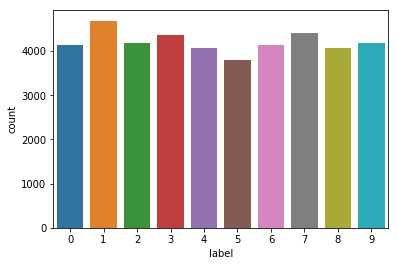

In [44]:
y_train = train["label"] # all labels
x_train = train.drop(labels = ["label"], axis = 1) # all pixel values

gph = sbn.countplot(y_train)
y_train.value_counts()

In [45]:
#normalize the data
x_train = x_train/255
test = test/255

Reshape the data to 3 dimensions (num_images, height = 28px, width = 28px ) as the python dataframe is 1D, it squeezes 28x28 image size into 1D matrix

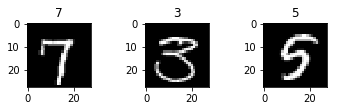

In [46]:
x_train = x_train.values.reshape(x_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [50]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
print(x_train.shape)

(42000, 28, 28, 1)


Similarly for test set, we reshape the array

In [53]:
x_test = test.values.reshape(test.shape[0], 28,28, 1)
print(x_test.shape)

(28000, 28, 28, 1)


**Label Encoding**

We use one hot encoding for the labelled images from 0-9 to a vector something like this ex: 4 can be represented as -> [0,0,0,0,1,0,0,0,0,0]

In [54]:
y_train = to_categorical(y_train)
num_classes = y_train.shape[1]
print(num_classes)

10


Now splitting training and validation set.
Splitted into 80-20 rule i.e 80% data for training and 20% for validation

In [57]:
random_seed = 2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=random_seed)


**Neural network architecture**

We use CNN architecture for digit recognition.


In [58]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

Compile the network

In [69]:
model.compile(optimizer=RMSprop(lr=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

**Cross validation**

We use ImageDataGenerator for the image augmentation.

In [70]:
x = x_train
y = y_train
gen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images)


In [71]:
train_batches = gen.flow(x_train, y_train, batch_size=64)
val_batches = gen.flow(x_val, y_val, batch_size=64)
batch_size=64

In [73]:
# Fit the model
history = model.fit_generator(generator = train_batches, epochs = 30 ,steps_per_epoch= x_train.shape[0] // batch_size, 
                    validation_data = val_batches, validation_steps = val_batches.n)   


Epoch 1/30
378/378 [==============================] - 414s 1s/step - loss: 0.2390 - accuracy: 0.9277 - val_loss: 0.0855 - val_accuracy: 0.9729
Epoch 2/30
378/378 [==============================] - 413s 1s/step - loss: 0.1370 - accuracy: 0.9587 - val_loss: 0.1815 - val_accuracy: 0.9774
Epoch 3/30
378/378 [==============================] - 420s 1s/step - loss: 0.1043 - accuracy: 0.9694 - val_loss: 0.0119 - val_accuracy: 0.9803
Epoch 4/30
378/378 [==============================] - 418s 1s/step - loss: 0.0931 - accuracy: 0.9725 - val_loss: 0.1482 - val_accuracy: 0.9782
Epoch 5/30
378/378 [==============================] - 415s 1s/step - loss: 0.0777 - accuracy: 0.9769 - val_loss: 0.0937 - val_accuracy: 0.9837
Epoch 6/30
378/378 [==============================] - 412s 1s/step - loss: 0.0760 - accuracy: 0.9769 - val_loss: 0.1030 - val_accuracy: 0.9859
Epoch 7/30
378/378 [==============================] - 410s 1s/step - loss: 0.0691 - accuracy: 0.9796 - val_loss: 0.0227 - val_accuracy: 0.9864

**Evaluate the model**

In [76]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

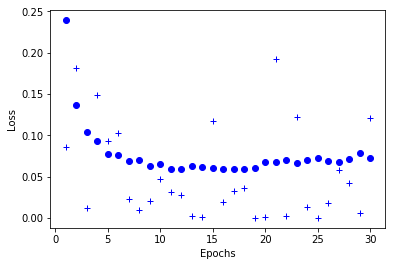

In [77]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

**Submitting predictions to Kaggle**

In [83]:
predictions = model.predict_classes(x_test, verbose=0)

In [ ]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("mnist_digit_recognition_result.csv", index=False, header=True)